### Citrus Leaves Dataset
* The original citrus dataset contains 759 images of healthy and unhealthy citrus fruits and leaves. However, for now we only export 594 images of citrus leaves with the following labels: Black Spot, Canker, Greening, and Healthy. The exported images are in PNG format and have ``256x256`` pixels.


### Imports

In [42]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [2]:
tfds.list_builders()[:2]

['abstract_reasoning', 'accentdb']

### Loading the Dataset

In [4]:
train = tfds.load('citrus_leaves', split='train')

In [5]:
train_images = np.array([i['image'].numpy().astype('float32')/255 for i in train])
train_labels = np.array([i['label'].numpy() for i in train])

### Class Names

In [12]:
class_names = ["Black spot", "canker", "greening", "healthy"]

### Visualising some Images

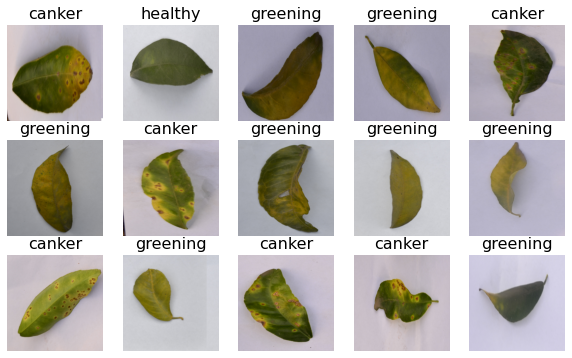

In [81]:
def display_images(images_and_classes, labels, cols=5):
  rows = 3
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, (image, label) in enumerate(zip(images_and_classes, labels)):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(class_names[label], fontsize=16)

display_images(train_images[:15], train_labels)

In [16]:
train_labels.shape, train_images.shape

((425,), (425, 256, 256, 3))

### Model Creation `CNN`

In [23]:
input_shape  = train_images[0].shape
output_shape = 3
input_shape, output_shape

((256, 256, 3), 3)

> Converting images to nmpy arrays to Tensorflow `tensors` and `one_hot_encode` the labels since I'm going to use `CategoricalCrossentropy()` 

In [31]:
y_train = tf.one_hot(train_labels, depth=4)
X_train = tf.convert_to_tensor(train_images)

In [36]:
model = keras.Sequential([
    keras.layers.Input(shape = input_shape),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(4, activation=keras.activations.softmax),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)       

In [37]:
model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=['acc']
)

### Plotting the model

In [52]:
keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [41]:
EPOCHS = 8
BATCH_SIZE = 32
VAL_SPLIT = .2
VERBOSE = 1

# LR_SCHEDULER = keras.callbacks.
LR_SCHEDULER = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(X_train, y_train, verbose=VERBOSE,
          validation_split=VAL_SPLIT, 
          epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=[LR_SCHEDULER])

Epoch 1/8
11/11 [==============================] - 140s 12s/step - loss: 0.6698 - acc: 0.6441 - val_loss: 0.6157 - val_acc: 0.7176
Epoch 2/8
11/11 [==============================] - 98s 9s/step - loss: 0.6261 - acc: 0.6735 - val_loss: 0.5945 - val_acc: 0.7647
Epoch 3/8
11/11 [==============================] - 103s 10s/step - loss: 0.6078 - acc: 0.7118 - val_loss: 0.5587 - val_acc: 0.7765
Epoch 4/8
11/11 [==============================] - 108s 10s/step - loss: 0.5706 - acc: 0.7647 - val_loss: 0.5308 - val_acc: 0.8118
Epoch 5/8
11/11 [==============================] - 85s 8s/step - loss: 0.5393 - acc: 0.7824 - val_loss: 0.4919 - val_acc: 0.8235
Epoch 6/8
11/11 [==============================] - 85s 8s/step - loss: 0.5148 - acc: 0.8000 - val_loss: 0.4694 - val_acc: 0.8118
Epoch 7/8
11/11 [==============================] - 80s 7s/step - loss: 0.4718 - acc: 0.8235 - val_loss: 0.4298 - val_acc: 0.8706
Epoch 8/8
11/11 [==============================] - 77s 7s/step - loss: 0.4305 - acc: 0.8412

### Ploting the model history

In [50]:
import pandas as pd

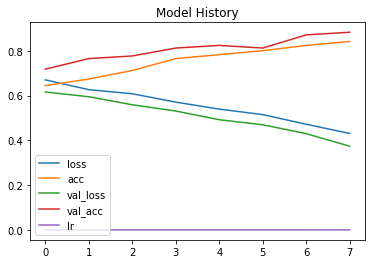

In [54]:
pd.DataFrame(history.history).plot(title="Model History")
plt.show()

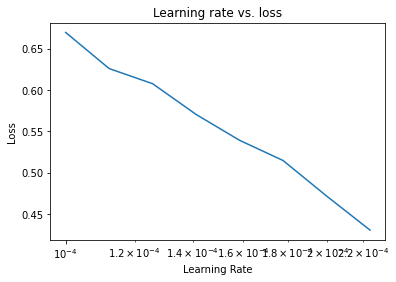

In [55]:
lrs = 1e-4 * (10 ** (np.arange(EPOCHS)/20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");
plt.show()

### Evaluating the model
> Since the dataset is small and we dont have the test dataset we can just use the training dataset to evaluate our model. We are going to use the confusion matrix to evaluate our model.

In [57]:
import itertools
from sklearn.metrics import confusion_matrix

In [58]:
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=16): 
      # Create the confustion matrix
      cm = confusion_matrix(y_true, y_pred)
      cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
      n_classes = cm.shape[0]
      # Plot the figure and make it pretty
      fig, ax = plt.subplots(figsize=figsize)
      cax = ax.matshow(cm, cmap=plt.cm.Blues) 
      fig.colorbar(cax)
    
      if classes:
        labels = classes
      else:
        labels = np.arange(cm.shape[0])
        
      ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="True label",
             xticks=np.arange(n_classes),
             yticks=np.arange(n_classes), 
             xticklabels=labels,
             yticklabels=labels)

      ax.xaxis.set_label_position("bottom")
      ax.xaxis.tick_bottom()

      threshold = (cm.max() + cm.min()) / 2.
      # Plot the text on each cell
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

In [68]:
y_pred = model.predict(X_train)

In [72]:
y_true = tf.argmax(y_train, axis=1)
y_pred_ = tf.argmax(y_pred, axis=1)
y_true[:5], y_pred_[:5]

(<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 3, 2, 2, 1], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 3, 2, 2, 2], dtype=int64)>)

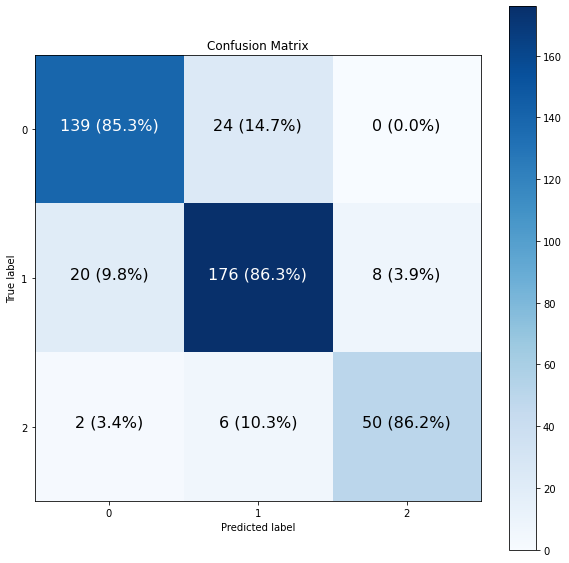

In [74]:
plot_confusion_matrix(y_true, y_pred_, figsize=(10, 10))

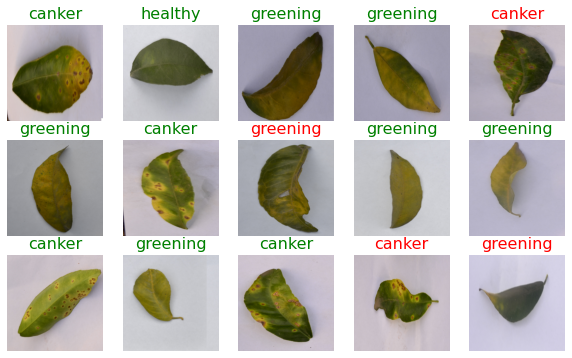

In [83]:
def plot_predictions_images(images_and_classes, labels_true, labels_pred, cols=5):
  rows = 3
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true, labels_pred)):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(class_names[label_true], color ='g' if label_true == label_pred else 'r', fontsize=16 )

plot_predictions_images(X_train[:15], y_true[:15], y_pred_[:15])